# Supervised Repertoire Classification

While solving a sequence classification can be useful in the cases where the label applies to every sequence in a sample (such as in tetramer-sorted T-cells), there are times where the label may truly only apply to a set of sequences. For example, in the case where one may sequence tumor-infiltrating lymphocytes (TIL) and  there is a label at the repertoire/sample level such as which therapy the sample received. In this case, there may be a structural signature within a set of sequences that is predictive but not every single sequence has that signature. This is a case where we want to learn what is the structural signature buried in a set of sequenes and which sequences carry this signature.

To demo this utility of a repertoire/sample level classifier, we will first upload dat from the Rudqvist dataseet. In this dataset, 20 mice with implanted tumors were treated with 4 modes of therapy (Control, 9H10, RT, or Combo). We want to know whether the TCRrepertoire from their tumors is predictive of the therapy they received.

In [1]:
import sys
sys.path.append('../../')
from DeepTCR.DeepTCR import DeepTCR_WF

# Instantiate training object
DTCR_WF = DeepTCR_WF('Tutorial')

#Load Data from directories
DTCR_WF.Get_Data(directory='../../Data/Rudqvist',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=1,count_column=2,v_beta_column=7,d_beta_column=14,j_beta_column=21)

Data Loaded


Following loading the data, we will split our data into test/train and then train the model.

In [2]:
DTCR_WF.Get_Train_Valid_Test(test_size=0.25)
DTCR_WF.Train()

Training_Statistics: 
 Epoch: 1/10000 Training loss: 1.36303 Validation loss: 1.39616 Testing loss: 1.39217 Training Accuracy: 0.41667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.33333
Training_Statistics: 
 Epoch: 2/10000 Training loss: 1.35307 Validation loss: 1.39335 Testing loss: 1.39188 Training Accuracy: 0.58333 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.33333
Training_Statistics: 
 Epoch: 3/10000 Training loss: 1.34306 Validation loss: 1.39066 Testing loss: 1.39195 Training Accuracy: 0.66667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.33333
Training_Statistics: 
 Epoch: 4/10000 Training loss: 1.33364 Validation loss: 1.38828 Testing loss: 1.39226 Training Accuracy: 0.66667 Validation Accuracy: 0.5 Testing Accuracy: 0.0 Testing AUC: 0.41667
Training_Statistics: 
 Epoch: 5/10000 Training loss: 1.32463 Validation loss: 1.38611 Testing loss: 1.39245 Training Accuracy: 0.66667 Validation Accuracy: 0.5 Testing Accuracy: 0.0 Tes

Training_Statistics: 
 Epoch: 43/10000 Training loss: 1.03692 Validation loss: 1.32678 Testing loss: 1.38747 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.41667
Training_Statistics: 
 Epoch: 44/10000 Training loss: 1.02918 Validation loss: 1.32505 Testing loss: 1.38688 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.41667
Training_Statistics: 
 Epoch: 45/10000 Training loss: 1.02135 Validation loss: 1.32336 Testing loss: 1.38625 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.41667
Training_Statistics: 
 Epoch: 46/10000 Training loss: 1.01361 Validation loss: 1.32163 Testing loss: 1.38556 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 47/10000 Training loss: 1.00580 Validation loss: 1.31983 Testing loss: 1.38479 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 

Training_Statistics: 
 Epoch: 88/10000 Training loss: 0.67411 Validation loss: 1.21709 Testing loss: 1.31656 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 89/10000 Training loss: 0.66607 Validation loss: 1.21396 Testing loss: 1.31441 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 90/10000 Training loss: 0.65812 Validation loss: 1.21088 Testing loss: 1.31226 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 91/10000 Training loss: 0.65020 Validation loss: 1.20769 Testing loss: 1.31008 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 92/10000 Training loss: 0.64228 Validation loss: 1.20431 Testing loss: 1.30785 Training Accuracy: 0.91667 Validation Accuracy: 0.5 Testing Accuracy: 0.25 Testing AUC:

Training_Statistics: 
 Epoch: 131/10000 Training loss: 0.36766 Validation loss: 1.07638 Testing loss: 1.24043 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 132/10000 Training loss: 0.36185 Validation loss: 1.07341 Testing loss: 1.23929 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 133/10000 Training loss: 0.35610 Validation loss: 1.07050 Testing loss: 1.23826 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 134/10000 Training loss: 0.35039 Validation loss: 1.06766 Testing loss: 1.23726 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.5
Training_Statistics: 
 Epoch: 135/10000 Training loss: 0.34475 Validation loss: 1.06484 Testing loss: 1.23628 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.5
Training_Statis

Training_Statistics: 
 Epoch: 174/10000 Training loss: 0.17898 Validation loss: 0.97679 Testing loss: 1.20097 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 175/10000 Training loss: 0.17601 Validation loss: 0.97534 Testing loss: 1.19993 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 176/10000 Training loss: 0.17307 Validation loss: 0.97364 Testing loss: 1.19893 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 177/10000 Training loss: 0.17018 Validation loss: 0.97205 Testing loss: 1.19802 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 178/10000 Training loss: 0.16737 Validation loss: 0.97045 Testing loss: 1.19736 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.6

Training_Statistics: 
 Epoch: 218/10000 Training loss: 0.08924 Validation loss: 0.94080 Testing loss: 1.16058 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 219/10000 Training loss: 0.08797 Validation loss: 0.94062 Testing loss: 1.15968 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 220/10000 Training loss: 0.08672 Validation loss: 0.94021 Testing loss: 1.15880 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 221/10000 Training loss: 0.08549 Validation loss: 0.93982 Testing loss: 1.15774 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.66667
Training_Statistics: 
 Epoch: 222/10000 Training loss: 0.08429 Validation loss: 0.93939 Testing loss: 1.15668 Training Accuracy: 1.0 Validation Accuracy: 0.5 Testing Accuracy: 0.5 Testing AUC: 0.6

Following training, we can view the performance through plotting the ROC curves.

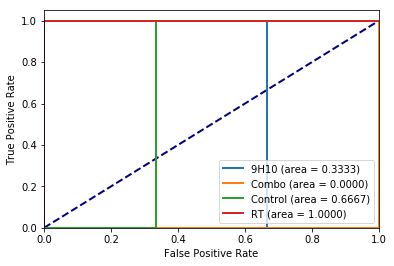

In [3]:
DTCR_WF.AUC_Curve()

You might notice that given how small this dataset is, doing one training split does not give us a good assesment for how predictive the TCR signature may be. In this case, we would want to use a K-fold cross validation to train on 19 of the samples and test on 1 and iterate until we've covered the entire cohort. When calling the K-fold cross validation command, one can provide the number of folds or if none is provided, it assumes a leave-one-out strategy.

In [4]:
%%capture
DTCR_WF.K_Fold_CrossVal()

We can then assess the performance once again through plotting the ROC curves.

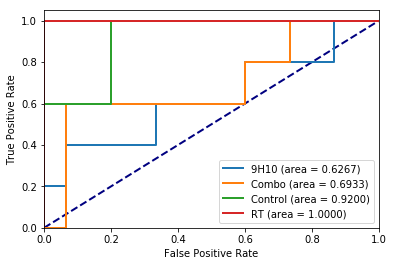

In [5]:
DTCR_WF.AUC_Curve()

Once our algorithm has been trained, we may want to see which sequences are the most strongly predicted for each label. To do this we will run the following command. The output of the command is a dictionary of dataframes within the object we can view. Additionally, these dataframes can be found in the results folder underneath the subdirectory 'Rep_Sequences'.

In [6]:
DTCR_WF.Representative_Sequences()

In [7]:
print(DTCR_WF.Rep_Seq['Control'])

      alpha            beta      v_beta      d_beta      j_beta v_alpha  \
11135  None      CASGDWEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
14919  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
13812  None    CASSDDRDEQYF  TCRBV13-01  unresolved  TCRBJ02-07    None   
11239  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
10858  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
15795  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
16650  None    CASRAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
16657  None  CASGLQMGKYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
13463  None    CESGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
13912  None   CASGDDSSYEQYF  TCRBV13-02  TCBDD01-01  TCRBJ02-07    None   

      j_alpha    Class         Sample      Freq  Counts          9H10  \
11135    None  Control  CONTROL-3.tsv  0.001773       2  4.833786e-08   
14919    None  Control  CONT

Furthermore, we may want to know which learned motifs are associated with a given label. To do this, we can run the following command with the label we want to know the predictive motifs for.

In [8]:
DTCR_WF.Motif_Identification('Control')

Motif Identification Completed


The motifs can then be found in fasta files in the results folder underneath (label)(alpha/beta)Motifs. These fasta fiels can then be used with "https://weblogo.berkeley.edu/logo.cgi" for motif visualization.

# Visualization

We can also visualize the learned latent space from the supervised repertoire classifier through plotting a UMAP representation of the sequences in two dimensions. This is called in the exact same way as the supervised sequence classifier. See that tutorial for more details on using this method.  

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


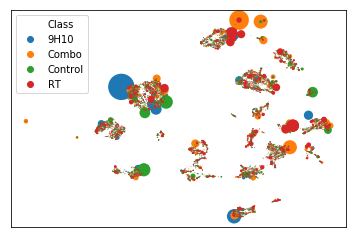

In [4]:
DTCR_WF.UMAP_Plot(by_class=True,freq_weight=True,scale=1000)

We can also visualize how the repertoires are related from this learned representation. This visualiztion is helpful when we want to compare how different TCR repertoires are related structurally. Once again, this is called in the same exact way as with the supervised sequence classifier. 

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 67.64601373672485 seconds
Jaccard graph constructed in 7.975973129272461 seconds
Wrote graph to binary file in 2.2678709030151367 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.917886
Louvain completed 21 runs in 14.316676378250122 seconds
PhenoGraph complete in 92.28688144683838 seconds
Clustering Done


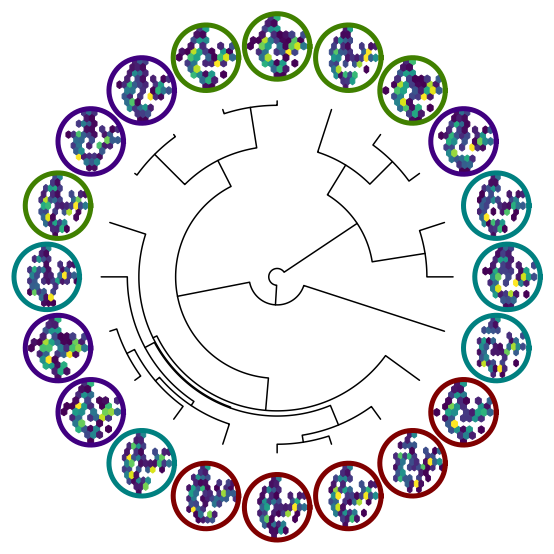

In [6]:
DTCR_WF.Repertoire_Dendrogram()